# Resnet18 knn classification

## Load libraries

In [92]:
import os
import math
from collections import Counter
import gdown
import glob

import numpy as np
import pandas as pd
import scipy
from PIL import Image as PILImage
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from IPython.display import Image as DisplayImage

Clonamos el repositorio de Github con el dataset

In [129]:
!git clone https://github.com/diego-taquiri/AutismSketchClassifier.git

Cloning into 'AutismSketchClassifier'...
remote: Enumerating objects: 873, done.
remote: Counting objects: 100% (873/873), done.
remote: Compressing objects: 100% (864/864), done.
remote: Total 873 (delta 65), reused 69 (delta 5), pack-reused 0
Receiving objects: 100% (873/873), 6.09 MiB | 8.15 MiB/s, done.
Resolving deltas: 100% (65/65), done.


Descargamos el modelo pre-entrenado

In [130]:
file_id = '1WZ_dmnln5-Xltfq_lOASLMPIMKjLzGWD'
output_dir = './AutismSketchClassifier/models'
output_path = os.path.join(output_dir, 'resnet18_quickdraw_pretrained.keras')
os.makedirs(output_dir, exist_ok=True)
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WZ_dmnln5-Xltfq_lOASLMPIMKjLzGWD
From (redirected): https://drive.google.com/uc?id=1WZ_dmnln5-Xltfq_lOASLMPIMKjLzGWD&confirm=t&uuid=2586be89-3c97-458a-ac75-9ecc1b9fe479
To: /Users/diegotaquiri/Desktop/proyectos/upch/cursos-2024-1/VS/proyecto-parcial/inference/final/AutismSketchClassifier/models/resnet18_quickdraw_pretrained.keras
100%|██████████| 137M/137M [00:03<00:00, 39.3MB/s] 


'./AutismSketchClassifier/models/resnet18_quickdraw_pretrained.keras'

## Cargar resnet18 pre-entrenada en Quick Draw dataset


In [131]:
model = load_model('./AutismSketchClassifier/models/resnet18_quickdraw_pretrained.keras')

In [132]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 28, 28, 64)           0         ['batch_normalization[0][0

Create a new model without the top layer


In [133]:
model = Model(inputs=model.input, outputs=model.get_layer('re_lu_16').output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 28, 28, 64)           0         ['batch_normalization[0]

## **Cargar dataset**

In [134]:
# Get image paths and labels
filenames = glob.glob('./AutismSketchClassifier/data/*/*.png')
labels = [os.path.basename(os.path.dirname(filename)) for filename in filenames]
filenames

['./AutismSketchClassifier/data/Ojos distanciados/eedibujo (10).png',
 './AutismSketchClassifier/data/Ojos distanciados/eedibujo (31).png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (67).png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (10).png',
 './AutismSketchClassifier/data/Ojos distanciados/eetmpzercsekj.png',
 './AutismSketchClassifier/data/Ojos distanciados/tmp94uqapi7.png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (60).png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (40).png',
 './AutismSketchClassifier/data/Ojos distanciados/eedibujo (17).png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (94).png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (9).png',
 './AutismSketchClassifier/data/Ojos distanciados/eeDrawing (15).png',
 './AutismSketchClassifier/data/Ojos distanciados/tmp6f9izlz1.png',
 './AutismSketchClassifier/data/Ojos distanciados/eetmphkvtqtnx.png',
 './AutismSketchCl

Mostramos las imagenes del dataset

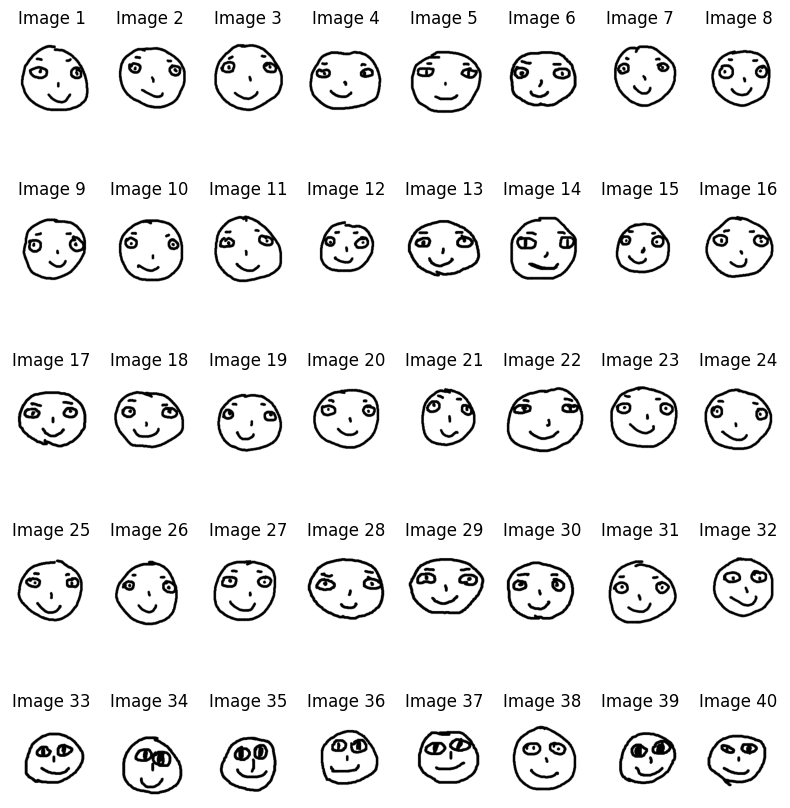

In [135]:
fig = plt.figure(figsize=(8, 9))
num_images = 40 #len(filenames)
images_per_row = 8
num_rows = (num_images // images_per_row) + int(num_images % images_per_row != 0)

for i in range(num_images):
    ax = fig.add_subplot(num_rows, images_per_row, i + 1)
    ax.imshow(imread(filenames[i]))
    ax.axis('off')
    ax.set_title(f"Image {i + 1}")

plt.tight_layout()
plt.show()

## Obtenemos un vector de representación por cada imagen

Preprocesamos y obtenemos un vector de representación para cada una de las imágenes del dataset

In [136]:
def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = PILImage.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

In [137]:
def extract_features_and_preprocessed_images(filenames):
    target_size=(28, 28)
    features = []
    preprocessed_images = []
    for filename in filenames:
        img = PILImage.open(filename)
        img = remove_transparency(img)
        img_resized = img.resize(target_size)
        img_gray = img_resized.convert('L')
        preprocessed_images.append(img_gray)
        x = image.img_to_array(img_gray)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        features.append(model.predict(x).ravel())
    return np.array(features), preprocessed_images

In [138]:
# Split the data into training and test sets
filenames_train, filenames_test, labels_train, labels_test = train_test_split(filenames, labels, test_size=0.2, stratify=labels, random_state=42)

# Extract features and preprocessed images
features_train, preprocessed_images_train = extract_features_and_preprocessed_images(filenames_train)
features_test, preprocessed_images_test = extract_features_and_preprocessed_images(filenames_test)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

print(f"Training features shape: {features_train.shape}")
print(f"Test features shape: {features_test.shape}")

1/1 [==============================] - 0s 38ms/step
Training features shape: (595, 8192)
Test features shape: (149, 8192)


Visualizamos

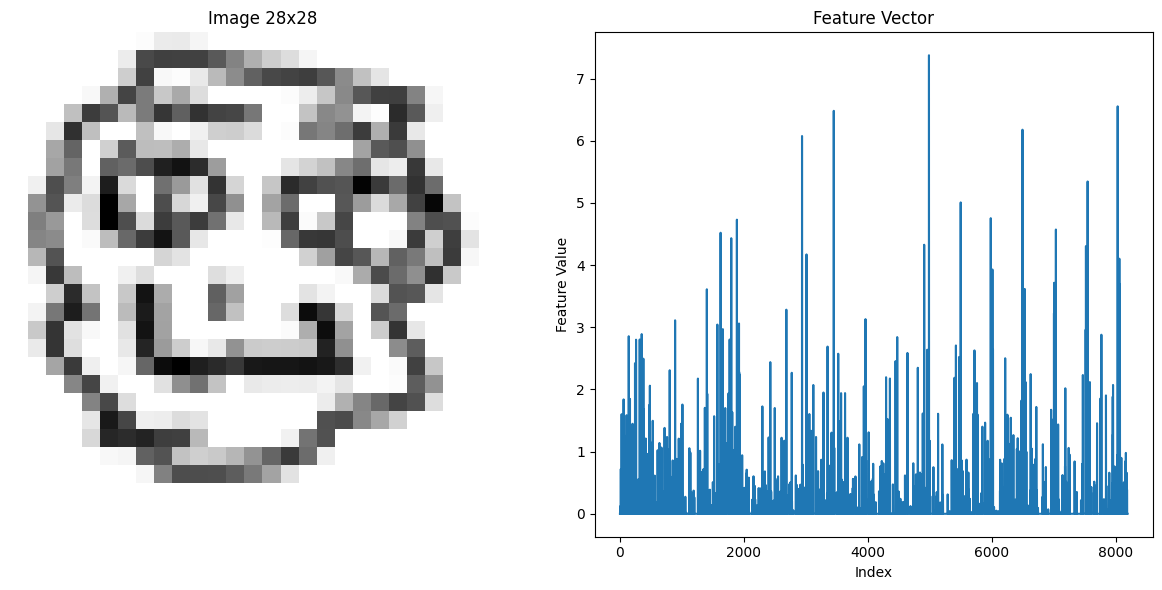

In [139]:
# Visualization
def visualize_image_and_features(img_gray, feature_vector):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the image on the first subplot
    axes[0].imshow(img_gray, cmap="gray")
    axes[0].set_title("Image 28x28")
    axes[0].axis("off")

    # Plot the feature vector on the second subplot
    axes[1].plot(feature_vector)
    axes[1].set_title("Feature Vector")
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Feature Value")

    plt.tight_layout()
    plt.show()

# Visualize one of the images and its feature vector
index_to_visualize = 13  # Change this index to visualize different images
visualize_image_and_features(preprocessed_images_train[index_to_visualize], features_train[index_to_visualize])


## **KNN encontramos imágenes más similares**


In [140]:
# tomar la distancia del coseno:
def distancia_cos(im1, im2):
  return 1 - np.dot(im1, im2) / (np.linalg.norm(im1) * np.linalg.norm(im2))

In [141]:
def k_vecinos_más_cercanos(vectores_train, vectores_test, index, k):
    vecinos = []
    im1 = vectores_test[index]  # vector of the test image we are referencing
    for i, im2 in enumerate(vectores_train):
        D = distancia_cos(im1, im2)
        vecinos.append([i, D])  # store the index of the training image and its distance

    vecinos.sort(key=lambda x: x[1])
    return [x[0] for x in vecinos[:k]]  # return the indices of the k closest neighbors

Query Image


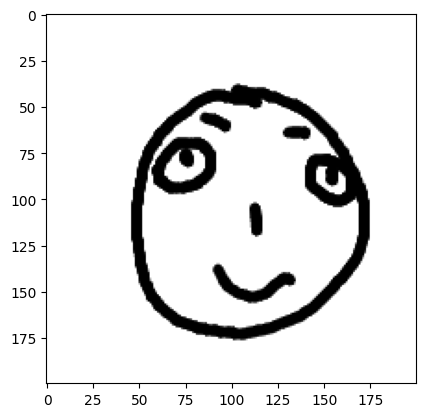

Retrieved Images (Total Images: 3 images)


In [142]:
# Display the query image and its nearest neighbors
idx = 1  # index of the test image we want to use as a query
k = 3  # number of neighbors to retrieve

print("Query Image")
query_img = PILImage.open(filenames_test[idx])
plt.imshow(query_img, cmap='gray')
plt.show()

# Get indices of k nearest neighbors from the training set
idxs = k_vecinos_más_cercanos(features_train, features_test, idx, k)

print("Retrieved Images (Total Images: {} images)".format(k))


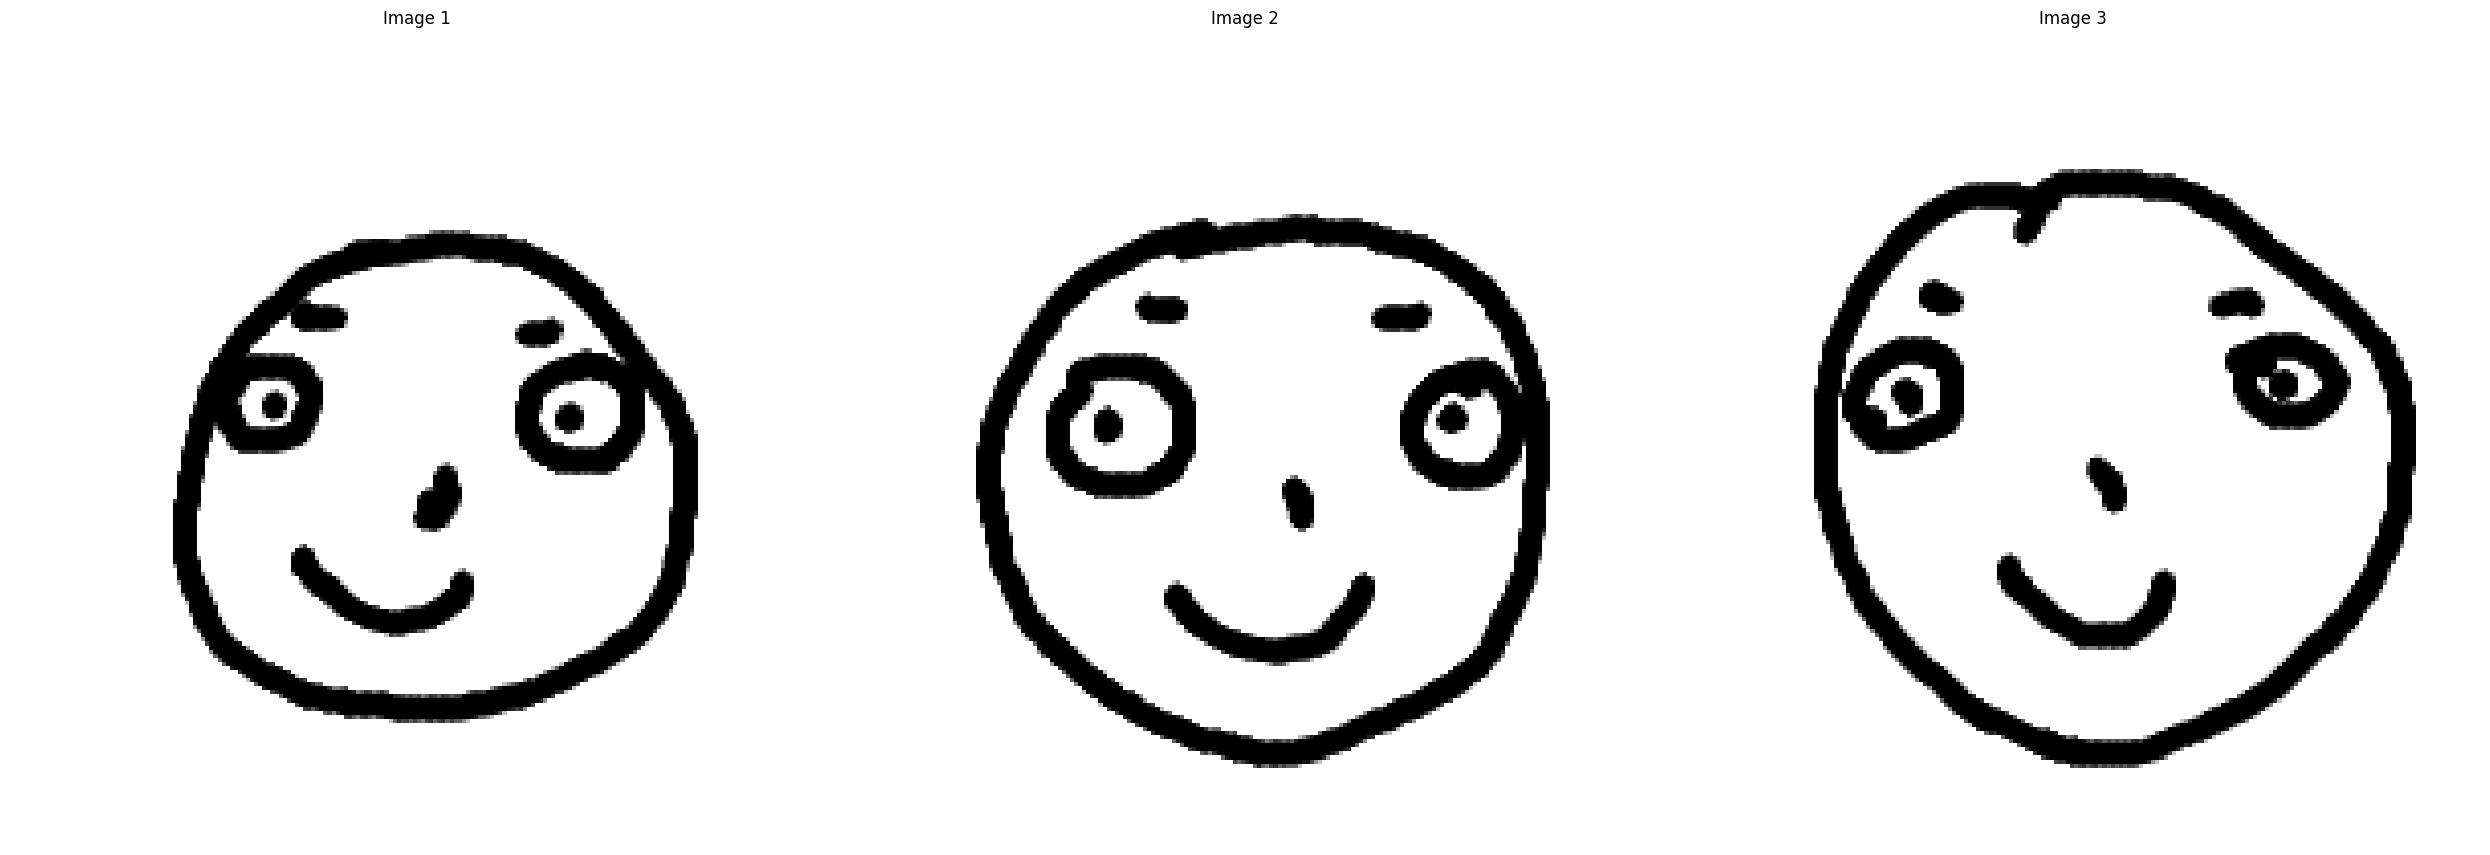

In [143]:
fig = plt.figure(figsize=(25, 9))

for i in range(k):
    ax = fig.add_subplot(1, k, i + 1) 
    img = PILImage.open(filenames_train[idxs[i]])
    ax.imshow(img, cmap='gray')
    ax.axis('off')  
    ax.set_title(f"Image {i + 1}") 

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

## **Clasificamos imágenes en base al KNN**

In [144]:
# Classify a single image from the test set
def classify_image(feature, features_train, labels_train, k=3):
    # Find k nearest neighbors in the training set
    neighbors_indices = k_vecinos_más_cercanos(features_train, [feature], 0, k)

    # Get the labels of the first k nearest neighbors
    neighbors_labels = [labels_train[i] for i in neighbors_indices]

    # Determine the majority label
    label_counter = Counter(neighbors_labels)
    majority_label = label_counter.most_common(1)[0][0]

    return majority_label

In [148]:
# Classify all images in the test set
predicted_labels = []
for feature_test in features_test:
    predicted_label = classify_image(feature_test, features_train, labels_train, k=10)
    predicted_labels.append(predicted_label)

# Convert to numpy array for easier comparison if needed
predicted_labels = np.array(predicted_labels)

# Output predicted labels
predicted_labels

array(['Sin cejas', 'Con ojos negros', 'Con cuello', 'Sin cejas',
       'Sin cejas', 'Sin cejas', 'Con ojos negros', 'Sin cejas',
       'Sin cejas', 'Ojos distanciados', 'Con cuello', 'Sin cejas',
       'Sonrisa grande', 'Sin cejas', 'Shaky lines', 'Sin cejas',
       'Con ojos negros', 'Con ojos negros', 'Sin cejas',
       'Con ojos negros', 'Sonrisa grande', 'Con ojos negros',
       'Sin cejas', 'Con ojos negros', 'Con cuello', 'Sin cejas',
       'Sin cejas', 'Shaky lines', 'Sin cejas', 'Sin cejas',
       'Ojos distanciados', 'Sin cejas', 'Sin cejas', 'Con ojos negros',
       'Dibujos Presquemáticos', 'Con cuello', 'Con ojos negros',
       'Ojos distanciados', 'Sonrisa grande', 'Sin cejas',
       'Con ojos negros', 'Sin cejas', 'Con ojos negros', 'Sin cejas',
       'Con ojos negros', 'Sonrisa grande', 'Shaky lines', 'Sin cejas',
       'Con ojos negros', 'Sin cejas', 'Sonrisa grande', 'Sin cejas',
       'Sin cejas', 'Con ojos negros', 'Con ojos negros',
       'Con ojos n

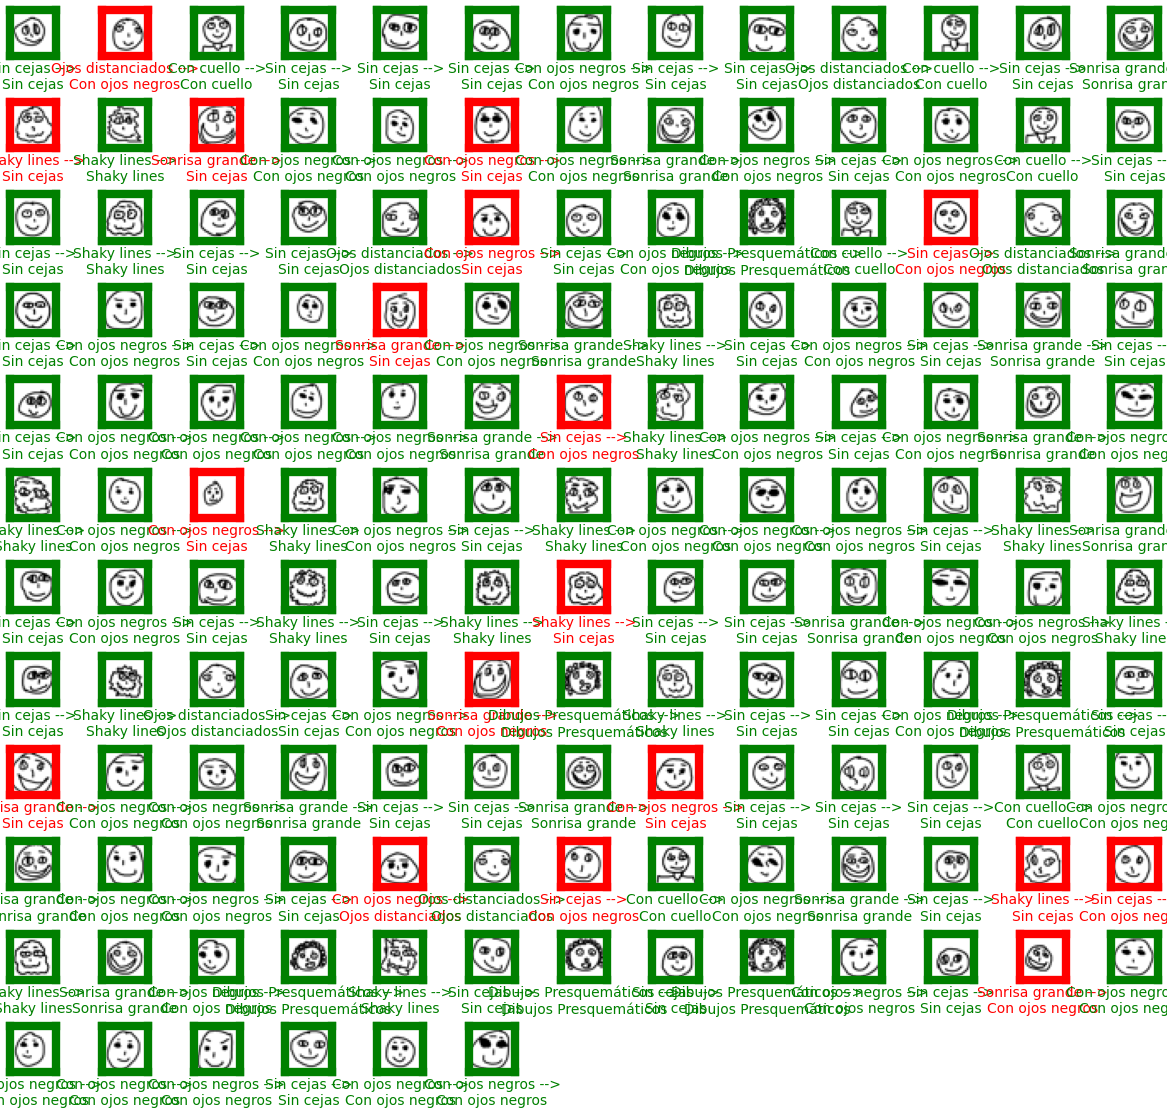

In [151]:
# Visualization of the predictions
def visualize_predictions(filenames, labels_true, labels_pred):
    numbers_to_display = min(149, len(filenames))
    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(15, 15))

    for i in range(numbers_to_display):
        img = PILImage.open(filenames[i])
        img = remove_transparency(img)
        img_resized = img.resize((28, 28))
        img_gray = img_resized.convert('L')
        x = np.array(img_gray)

        y_true = labels_true[i]
        y_pred = labels_pred[i]

        color = 'green' if y_true == y_pred else 'red'

        plt.subplot(num_cells, num_cells, i + 1)
        plt.imshow(x, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(f"{y_true} -->\n{y_pred}", color=color)

        # Add border color
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(6)

    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()


# Visualize the results
visualize_predictions(filenames_test, labels_test, predicted_labels)

Calculamos el accuracy en el test set

In [152]:
# Calculate accuracy
accuracy = accuracy_score(labels_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.88
